#Install packages and load libraries

Install non-native packages



In [1]:
%%capture
!pip install ipynb
!pip install scikit-learn==0.22.2.post1
!pip install -q xlrd

Import common packages

In [2]:
%%capture
import argparse, cProfile, datetime
from functools import reduce
import glob
import itertools as it
from multiprocessing import cpu_count, Pool
import networkx as nx
import numpy as np
import os

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random, re, shutil
from scipy.stats import hmean
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import auc, average_precision_score, precision_recall_curve
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import subprocess as sp
import sys
import tempfile as tf
import time
from tqdm import tqdm as progressMonitor

Enable Google Colab, mount drives, and load proprietary modules...

In [3]:
%%capture
from google.colab import drive, files, output
drive.mount('/content/drive', force_remount=True)
!rm -r sample_data/

In [4]:
#useful to keep track of sys vars so as to better monitor space remaining
print(cpu_count())
sysVars = list(globals().keys())

2


In [5]:
rootDir = '/content/drive/My Drive/'
workDir = rootDir + 'Primary Research/JLMwSCBC_notebook/'
workDir_ph2 = rootDir + 'elcfs_protein_complex_modeling/'  #phase 2 directory
workDir_elcfs = rootDir + 'Primary Research/proteinPairs_complexMaps/' #modeling library
complexesPath = workDir + 'complexPredictions/'
cwd = '/content/drive/My Drive/proteinPairs_complexMaps/' #obsolete?

#sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/')
#sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/proteinPairs_complexMaps/')
#cwd = '/content/drive/My Drive/Colab Notebooks/proteinPairs_complexMaps/'
#workDir = '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/'

sys.path.insert(0, rootDir)
for p in workDir, workDir_elcfs, workDir_ph2: sys.path.append(p)

In [6]:
from util import ppiPrediction_v2, dataProcessing, modelEvaluating, getData, getComplexes, getPairs_analysis, getComplexes_analysis, getAllCliques_gwMods
from utils import operations, reference, alertMe
pushoverKey_user = 'uith8rmy2npjj1oqpjwcanow3un984'
pushoverAPI = 'aw4v3424kaznrw598r6qge9icddwg7'

#Load data

In [ ]:
#for pickledFile in glob.glob(cwd + '*pkl'):
for pickledFile in glob.glob('./*.pkl'):
  globals()[pickledFile.split('/')[-1].split('.0')[0].split('.pkl')[0]] = pickle.load(open(pickledFile, 'rb'))

In [ ]:
for pickledFile in glob.glob('./*.pkl'):
  print(pickledFile.split('/')[-1].split('.0')[0].split('.pkl')[0])

pairData_drew2017_drew2021_WLM_ribosomeTheoretical
ribosomalSubunits_multipleIDs
corumComplexes_uniprotIDs_2018
drew2017_drew2021_lm2019_stringClusters
corumComplexes_geneIDs_2018


In [ ]:
corum2018Complexes_humanSubset = pickle.load(open('./corum2018Complexes_humanSubset.pkl', 'rb'))

In [ ]:
corum2018Complexes_humanGeneids = corum2018Complexes_humanSubset['corum2018Complexes_humanGeneids']

In [ ]:
for key, val in corum2018Complexes_humanSubset.items():
  corum2018Complexes_humanSubset[key] = set(val)

In [ ]:
corum2018Complexes_humanGeneids

In [ ]:
dataPartitions_dirs = workDir + \
  'dataPartitions/drew+jlm+kaggle+gtex+phantom+scbc/drew+jlm+kaggle+gtex+phantom+scbc_5CV*/'
modelPerformances_dirs = workDir + \
  'modelPerformance/modelsPerformance_expandedPairs_drewPlus+LM+SCBC+FGK_5CV*/'
allLabels_nonSpecific, allPredictions_nonSpecific = \
  getComplexes_analysis.acquirePredictions(dataPartitions_dirs, modelPerformances_dirs,
                                           'expandedPairs_drewPlus+LM+SCBC+FGK_5CV')
allInteractions_nonSpecific = pd.DataFrame(
    data=allLabels_nonSpecific, columns=['label', 'geneIDi', 'geneIDii'], dtype=str)
allInteractions_nonSpecific = pd.concat(
    [allInteractions_nonSpecific,
     pd.DataFrame(data={'confidenceVals': allPredictions_nonSpecific})], axis=1)

The lengths of the labels's and predictions's datasets are 1038169 and 1038169 respectively.


In [ ]:
scoresLM2019 = drew2017_drew2021_lm2019_stringPairs['LM2019'][2].to_numpy()
scoresLM2019_sorted = np.sort(scoresLM2019)
scoresLM2019_sortedRev = scoresLM2019_sorted[::-1]

top02per_point = round(len(scoresLM2019_sortedRev)*(0.02/100))
print(top02per_point)
top05per_point = round(len(scoresLM2019_sortedRev)*(0.05/100))
print(top05per_point)

scoresLM2019_top02per = scoresLM2019_sortedRev[:top02per_point]
print(len(scoresLM2019_top02per))
print(scoresLM2019_top02per[-1])
scoresLM2019_top05per = scoresLM2019_sortedRev[:top05per_point]
print(len(scoresLM2019_top05per))
print(scoresLM2019_top05per[-1])

4123
10308
4123
0.86627
10308
0.77396


#CORUM analysis

In [ ]:
jindex_corum2012 = np.empty((len(corumComplexes_geneIDs_2012), len(corumComplexes_geneIDs_2012)))
for i, complexSeti in zip(np.arange(len(list(corumComplexes_geneIDs_2012))), list(corumComplexes_geneIDs_2012)):
  for j, complexSetj in zip(np.arange(len(list(corumComplexes_geneIDs_2012))), list(corumComplexes_geneIDs_2012)):
    jindex_corum2012[i, j] = len(complexSeti.intersection(complexSetj))/len(complexSeti.union(complexSetj))
jindex_corum2012 = np.tril(jindex_corum2012, k=-1)
jiCORUM_2012 = len(jindex_corum2012[jindex_corum2012>=0.6])/len(corumComplexes_geneIDs_2012)
print(str(jiCORUM_2012) + '% share a Jaccard similarity index of >= 0.6.')

jindex_corum2018 = np.empty((len(corumComplexes_geneIDs_2018), len(corumComplexes_geneIDs_2018)))
for i, complexSeti in zip(np.arange(len(list(corumComplexes_geneIDs_2018))), list(corumComplexes_geneIDs_2018)):
  for j, complexSetj in zip(np.arange(len(list(corumComplexes_geneIDs_2018))), list(corumComplexes_geneIDs_2018)):
    jindex_corum2018[i, j] = len(complexSeti.intersection(complexSetj))/len(complexSeti.union(complexSetj))
jindex_corum2018 = np.tril(jindex_corum2018, k=-1)
jiCORUM_2018 = len(jindex_corum2018[jindex_corum2018>=0.6])/len(corumComplexes_geneIDs_2018)
print(str(jiCORUM_2018) + '% share a Jaccard similarity index of >= 0.6.')

0.3031325301204819% share a Jaccard similarity index of >= 0.6.
0.3080459770114943% share a Jaccard similarity index of >= 0.6.


#Optimal thresholds for the Drew 2017 and 2021 studies include 0.20509 and {1.0, 0.7, 0.5, 0.04, 0.02} respectively.

##Drew 2017 (382/385) and (911/941) small and large ribosomal protein pairs made it above threshold

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].loc[
                                                                   pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['smallRibosomal_allPairs_geneid'])), :].shape

(385, 4)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].loc[
                                                                   pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['largeRibosomal_allPairs_geneid'])), :].shape

(941, 4)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].loc[
                                                                   (pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['smallRibosomal_allPairs_geneid'])) & pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'][2] > 0.20509), :].shape

(382, 4)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].loc[
                                                                   (pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['largeRibosomal_allPairs_geneid'])) & pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2017'][2] > 0.20509), :].shape

(911, 4)

##Drew 2021 (all ribosomal protein pairs made it above threshold)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].loc[
                                                                   pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['smallRibosomal_allPairs_geneid'])), :].shape

(465, 4)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].loc[
                                                                   pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['largeRibosomal_allPairs_geneid'])), :].shape

(1034, 4)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].loc[
                                                                   (pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['smallRibosomal_allPairs_geneid'])) & pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'][2] > 0.02), :].shape

(465, 4)

In [ ]:
pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].loc[
                                                                   (pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'].pairsFrozen.isin(
    list(pairData_drew2017_drew2021_WLM_ribosomeTheoretical['largeRibosomal_allPairs_geneid'])) & pairData_drew2017_drew2021_WLM_ribosomeTheoretical['drew2021'][2] > 0.02), :].shape

(1034, 4)

#Study of ribosomal subunits

In [ ]:
srPreds_humap1Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['smallRibosomal_subunitGeneid'], predictedComplexes_humap1, jindex=0.5, returnResults=True)
lrPreds_humap1Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['largeRibosomal_subunitGeneid'], predictedComplexes_humap1, jindex=0.5, returnResults=True)
srPreds_humap2Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['smallRibosomal_subunitUniprotid'], predictedComplexes_humap2, jindex=0.5, returnResults=True)
lrPreds_humap2Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['largeRibosomal_subunitUniprotid'], predictedComplexes_humap2, jindex=0.5, returnResults=True)

Proteins overlap with refComplex: 31 out of 31.
# of predictions overlapping with reference complex: 10
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 46 out of 47.
# of predictions overlapping with reference complex: 13
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 28 out of 31.
# of predictions overlapping with reference complex: 23
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 1
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 46 out of 47.
# of predictions ov

In [ ]:
srPreds_lm2019_top02Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['smallRibosomal_subunitGeneid'], predictedComplexes_lm2019_top02, jindex=0.5, returnResults=True)
lrPreds_lm2019_top02Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['largeRibosomal_subunitGeneid'], predictedComplexes_lm2019_top02, jindex=0.5, returnResults=True)
srPreds_lm2019_top05Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['smallRibosomal_subunitGeneid'], predictedComplexes_lm2019_top05, jindex=0.5, returnResults=True)
lrPreds_lm2019_top05Res = getComplexes_analysis.quickCompare_contrast(ribosomeColab['largeRibosomal_subunitGeneid'], predictedComplexes_lm2019_top05, jindex=0.5, returnResults=True)

Proteins overlap with refComplex: 23 out of 31.
# of predictions overlapping with reference complex: 916
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 32 out of 47.
# of predictions overlapping with reference complex: 986
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 17
Max overlap of predictions with reference complex having Jaccard index of >=0.5: 22.0
Mean overlap of predictions with reference complex having Jaccard index of >=0.5: 21.11764705882353
____________________________________________________
Proteins overlap with refComplex: 25 out of 31.
# of predictions overlapping with reference complex: 5564
# of predictions for which refComplex is a superset: 0
# of predictions for which r

#Study (all) reference CORUM complexes

##Assess performance from alternate studies

In [ ]:
def condenseRef_proteinSet(refComplex_set):
    refProteins_set = set()
    for complexSet in list(refComplex_set):
        refProteins_set = refProteins_set.union(list(complexSet))
    print(len(refProteins_set))

    return refProteins_set

In [ ]:
refProteins_set = condenseRef_proteinSet(corum2018Complexes_humanSubset['corum2018Complexes_humanGeneids'])

3420


In [ ]:
type(drew2017_drew2021_lm2019_stringClusters['lm2019_top02per'])

set

In [ ]:
predictedComplexes_adj = set([frozenset(refProteins_set.intersection(ele)) for ele in list(drew2017_drew2021_lm2019_stringClusters['lm2019_top02per'])])

In [ ]:
predictedComplexes_adj

{frozenset({'6142', '6143', '6175', '6187', '6193'}),
 frozenset({'23020', '56949', '9416'}),
 frozenset({'25873',
            '3921',
            '4736',
            '6122',
            '6124',
            '6125',
            '6128',
            '6129',
            '6130',
            '6134',
            '6141',
            '6143',
            '6156',
            '6175',
            '6187',
            '6188',
            '6193',
            '6194',
            '6201',
            '6202',
            '6204',
            '6206',
            '6207',
            '6217',
            '6223',
            '6224',
            '6228',
            '6233'}),
 frozenset({'23481',
            '25873',
            '6142',
            '6143',
            '6188',
            '6193',
            '6194',
            '6209',
            '6217',
            '6223'}),
 frozenset({'4673',
            '4736',
            '6122',
            '6128',
            '6134',
            '6152',
            '6161',

In [ ]:
reconFrac_maxHumap1, _, purityFrac_maxHumap1, _ = getComplexes_analysis.compareContrast_all(corumComplexes_geneIDs_2012, predictedComplexes_humap1, similarityMetric=0)

Proteins overlap with refComplex: 6 out of 6.
# of predictions overlapping with reference complex: 11
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 1
# of predictions with >= 0.6 Jaccard index: 4659
Max overlap of predictions with reference complex having Jaccard index of >=0: 3.0
Mean overlap of predictions with reference complex having Jaccard index of >=0: 0.0034342133505044
____________________________________________________
Proteins overlap with refComplex: 3 out of 4.
# of predictions overlapping with reference complex: 13
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 4659
Max overlap of predictions with reference complex having Jaccard index of >=0: 1.0
Mean overlap of predictions with reference complex having Jaccard index of >=0: 0.002790298347284825
____________________________________________________
Proteins o

/content/drive/My Drive/proteinPairs_complexMaps/util/getComplexes_analysis.py:164: RuntimeWarning: invalid value encountered in double_scalars
  results['reconstitutionFraction_max'] = np.amax(overlapInterest)/len(refComplex)
/content/drive/My Drive/proteinPairs_complexMaps/util/getComplexes_analysis.py:165: RuntimeWarning: invalid value encountered in double_scalars
  results['reconstitutionFraction_mean'] = np.mean(overlapInterest)/len(refComplex)


Streaming output truncated to the last 5000 lines.
Proteins overlap with refComplex: 5 out of 5.
# of predictions overlapping with reference complex: 11
# of predictions for which refComplex is a superset: 1
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 4659
Max overlap of predictions with reference complex having Jaccard index of >=0: 5.0
Mean overlap of predictions with reference complex having Jaccard index of >=0: 0.0051513200257566
____________________________________________________
Proteins overlap with refComplex: 0 out of 4.
# of predictions overlapping with reference complex: 0
# of predictions for which refComplex is a superset: 4659
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 4659
Max overlap of predictions with reference complex having Jaccard index of >=0: 0.0
Mean overlap of predictions with reference complex having Jaccard index of >=0: 0.0
___________________________

In [ ]:
reconFrac_maxHumap2, reconFrac_meanHumap2, purityFrac_maxHumap2, purityFrac_meanHumap2 = getComplexes_analysis.compareContrast_all(corumComplexes_uniprotIDs_2018, predictedComplexes_humap2)

Streaming output truncated to the last 5000 lines.
Proteins overlap with refComplex: 1 out of 2.
# of predictions overlapping with reference complex: 3
# of predictions for which refComplex is a superset: 3
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 2 out of 2.
# of predictions overlapping with reference complex: 5
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 0 out of 1.
# of predictions overlapping with reference complex: 0
# of predictions for which refComplex is a superset: 6964
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with 

In [ ]:
huMAPs_corumAnalyses = \
  {
      'reconFrac_maxHumap1': reconFrac_maxHumap1,
   'reconFrac_meanHumap1': reconFrac_meanHumap1,
   'purityFrac_maxHumap1': purityFrac_maxHumap1,
   'purityFrac_meanHumap1': purityFrac_meanHumap1,
   'reconFrac_maxHumap2': reconFrac_maxHumap2,
   'reconFrac_meanHumap2': reconFrac_meanHumap2,
   'purityFrac_maxHumap2': purityFrac_maxHumap2,
   'purityFrac_meanHumap2': purityFrac_meanHumap2
   }

pickle.dump(huMAPs_corumAnalyses, open('./huMAPs_corumAnalyses_reconPlus_purity.pkl', 'wb'))

In [ ]:
huMAPs_corumAnalyses = \
  pickle.load(open('/content/huMAPs_corumAnalyses_reconPlus_purity.pkl', 'rb'))

reconFrac_maxHumap1 = huMAPs_corumAnalyses['reconFrac_maxHumap1']
reconFrac_meanHumap1 = huMAPs_corumAnalyses['reconFrac_meanHumap1']
purityFrac_maxHumap1 = huMAPs_corumAnalyses['purityFrac_maxHumap1']
purityFrac_meanHumap1 = huMAPs_corumAnalyses['purityFrac_meanHumap1']
reconFrac_maxHumap2 = huMAPs_corumAnalyses['reconFrac_maxHumap2']
reconFrac_meanHumap2 = huMAPs_corumAnalyses['reconFrac_meanHumap2']
purityFrac_maxHumap2 = huMAPs_corumAnalyses['purityFrac_maxHumap2']
purityFrac_meanHumap2 = huMAPs_corumAnalyses['purityFrac_meanHumap2']

<Figure size 432x288 with 0 Axes>

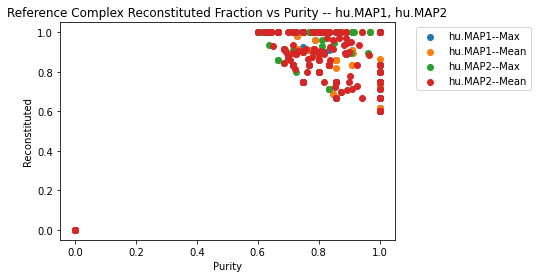

In [ ]:
plt.clf()
fig, ax = plt.subplots()
plt.title('Reference Complex Reconstituted Fraction vs Purity -- hu.MAP1, hu.MAP2')
plt.scatter(x=purityFrac_maxHumap1, y=reconFrac_maxHumap1, label='hu.MAP1--Max')
plt.scatter(x=purityFrac_meanHumap1, y=reconFrac_meanHumap1, label='hu.MAP1--Mean')
plt.scatter(x=purityFrac_maxHumap2, y=reconFrac_maxHumap2, label='hu.MAP2--Max')
plt.scatter(x=purityFrac_meanHumap2, y=reconFrac_meanHumap2, label='hu.MAP2--Mean')
plt.xlabel('Purity')
plt.ylabel('Reconstituted')
plt.legend(bbox_to_anchor=(1.05, 1))
fig.savefig('reconFrac_vPurity_huMAP1+huMAP2_max+mean.svg', bbox_inches='tight', dpi=1200, format='svg')

In [ ]:
reconFrac_maxLM2019_top02, reconFrac_meanLM2019_top02, purityFrac_maxLM2019_top02, purityFrac_meanLM2019_top02 = getComplexes_analysis.compareContrast_all(corumComplexes_geneIDs_2018, predictedComplexes_lm2019_top02)
reconFrac_maxLM2019_top05, reconFrac_meanLM2019_top05, purityFrac_maxLM2019_top05, purityFrac_meanLM2019_top05 = getComplexes_analysis.compareContrast_all(corumComplexes_geneIDs_2018, predictedComplexes_lm2019_top05)

Streaming output truncated to the last 5000 lines.
# of predictions for which refComplex is a superset: 0
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 0 out of 2.
# of predictions overlapping with reference complex: 0
# of predictions for which refComplex is a superset: 7758
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 0 out of 3.
# of predictions overlapping with reference complex: 0
# of predictions for which refComplex is a superset: 7758
# of predictions for which refComplex is a subset: 0
# of predictions with >= 0.6 Jaccard index: 0
____________________________________________________
Proteins overlap with refComplex: 4 out of 8.
# of predictions overlapping with reference complex: 7
# of predictions fo

In [ ]:
lm2019_corumAnalyses = \
  {
      'reconFrac_maxLM2019_top02': reconFrac_maxLM2019_top02,
   'reconFrac_meanLM2019_top02': reconFrac_meanLM2019_top02,
   'purityFrac_maxLM2019_top02': purityFrac_maxLM2019_top02,
   'purityFrac_meanLM2019_top02': purityFrac_meanLM2019_top02,
   'reconFrac_maxLM2019_top05': reconFrac_maxLM2019_top05,
   'reconFrac_meanLM2019_top05': reconFrac_meanLM2019_top05,
   'purityFrac_maxLM2019_top05': purityFrac_maxLM2019_top05,
   'purityFrac_meanLM2019_top05': purityFrac_meanLM2019_top05
   }

pickle.dump(lm2019_corumAnalyses, open('./lm2019_corumAnalyses_reconPlus_purity.pkl', 'wb'))

In [ ]:
lm2019_corumAnalyses = \
  pickle.load(open('/content/lm2019_corumAnalyses_reconPlus_purity.pkl', 'rb'))

reconFrac_maxLM2019_top02 = lm2019_corumAnalyses['reconFrac_maxLM2019_top02']
reconFrac_meanLM2019_top02 = lm2019_corumAnalyses['reconFrac_meanLM2019_top02']
purityFrac_maxLM2019_top02 = lm2019_corumAnalyses['purityFrac_maxLM2019_top02']
purityFrac_meanLM2019_top02 = lm2019_corumAnalyses['purityFrac_meanLM2019_top02']
reconFrac_maxLM2019_top05 = lm2019_corumAnalyses['reconFrac_maxLM2019_top05']
reconFrac_meanLM2019_top05 = lm2019_corumAnalyses['reconFrac_meanLM2019_top05']
purityFrac_maxLM2019_top05 = lm2019_corumAnalyses['purityFrac_maxLM2019_top05']
purityFrac_meanLM2019_top05 = lm2019_corumAnalyses['purityFrac_meanLM2019_top05']

<Figure size 432x288 with 0 Axes>

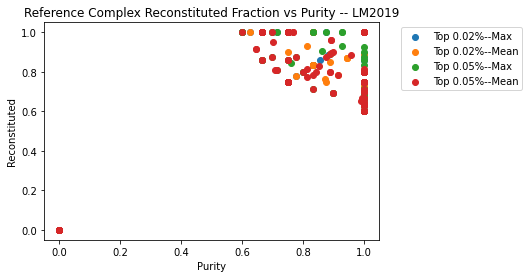

In [ ]:
plt.clf()
fig, ax = plt.subplots()
plt.title('Reference Complex Reconstituted Fraction vs Purity -- LM2019')
plt.scatter(x=purityFrac_maxLM2019_top02, y=reconFrac_maxLM2019_top02, label='Top 0.02%--Max')
plt.scatter(x=purityFrac_meanLM2019_top02, y=reconFrac_meanLM2019_top02, label='Top 0.02%--Mean')
plt.scatter(x=purityFrac_maxLM2019_top05, y=reconFrac_maxLM2019_top05, label='Top 0.05%--Max')
plt.scatter(x=purityFrac_meanLM2019_top05, y=reconFrac_meanLM2019_top05, label='Top 0.05%--Mean')
plt.xlabel('Purity')
plt.ylabel('Reconstituted')
plt.legend(bbox_to_anchor=(1.05, 1))
fig.savefig('reconFrac_vPurity_LM2019_bothThresholds_max+mean.svg', bbox_inches='tight', dpi=1200, format='svg')

##Assess performance from partition-model

###Priming (Save some time by checking against only complexes for which there were available outcomes in the other studies)

In [ ]:
corumDF_2018 = pd.read_excel('./corum.xlsx', sheet_name='allComplexesCore')
corumComplexes_uniprotIDs_2018Rev_indices = np.ones((len(corumComplexes_uniprotIDs_2018), 1))
corumComplexes_uniprotIDs_2018Rev_indices[:] = -1
corumComplexes_geneIDs_2018Rev_indices = np.ones((len(corumComplexes_geneIDs_2018), 1))
corumComplexes_geneIDs_2018Rev_indices[:] = -1

for idx in corumDF_2018.index:
    placeholderUniprotid = \
      frozenset([ele for ele in re.split(',\(|\(|\),|\)|\t|\s|;|,',
                                          corumDF_2018.loc[idx, 'subunits(UniProt IDs)']) if ele])

    placeholderGeneid = \
      frozenset([ele for ele in re.split(',\(|\(|\),|\)|\t|\s|;|,',
                                          corumDF_2018.loc[idx, 'subunits(Entrez IDs)']) if ele])

    for idxUniprotid in np.arange(len(corumComplexes_uniprotIDs_2018)):
      if placeholderUniprotid==list(corumComplexes_uniprotIDs_2018)[idxUniprotid]:
        corumComplexes_uniprotIDs_2018Rev_indices[idxUniprotid] = idx
        break

    for idxGeneid in np.arange(len(corumComplexes_geneIDs_2018)):
      if placeholderGeneid==list(corumComplexes_geneIDs_2018)[idxGeneid]:
        corumComplexes_geneIDs_2018Rev_indices[idxGeneid] = idx
        break

In [ ]:
limitFocus_indices = \
  list(corumComplexes_uniprotIDs_2018Rev_indices[np.nonzero(maxReconstituted_humap2)]) + \
  list(corumComplexes_geneIDs_2018Rev_indices[np.nonzero(maxReconstituted_lm2019_top02)]) + \
  list(corumComplexes_geneIDs_2018Rev_indices[np.nonzero(maxReconstituted_lm2019_top05)])

limitFocus_indices = [int(ele) for ele in limitFocus_indices]

In [ ]:
corum2018_focusComplexes = dict()
corum2018_focusSet = set()
for focusIdx in limitFocus_indices:
  placeholder = \
    frozenset([ele for ele in re.split(',\(|\(|\),|\)|\t|\s|;|,',
                                        corumDF_2018.loc[focusIdx, 'subunits(Entrez IDs)']) if ele])
  if len(placeholder) != 0:
    corum2018_focusComplexes[focusIdx] = placeholder
    corum2018_focusSet = corum2018_focusSet.union(corum2018_focusComplexes[focusIdx])

corum2018_focusComplexes = set([ele for ele in corum2018_focusComplexes.values()])

In [ ]:
pickle.dump(corum2018_focusComplexes, open('./corum2018_humapLM_sharedOutcomes.pkl', 'wb'))

###Main1

In [ ]:
cellSpecific_probsLabels = pickle.load(open(workDir + 'cellSpecific_probsLabels.pkl', 'rb'))

In [ ]:
cellSpecific_probsLabels.keys()

In [ ]:
cellSpecific_probsLabels['labels'].shape

In [ ]:
allInteractions_nonSpecific = pd.concat(
    (cellSpecific_probsLabels['labels'].loc[:, ['geneIDi', 'geneIDii']],
     cellSpecific_probsLabels['probs']['mcf7']),
    axis=1)

allInteractions_nonSpecific.head()

,geneIDi,geneIDii,confidenceVals
0,27316,24144,0.080337
1,7846,1938,0.058749
2,56949,4670,0.024688
3,6205,6136,0.781380
4,58517,6633,0.056897


In [ ]:
print('initialization phase...')
'''
srPreds_acrossThresholds_ji6 = dict()
lrPreds_acrossThresholds_ji6 = dict()
srPreds_acrossThresholds_ji5 = dict()
lrPreds_acrossThresholds_ji5 = dict()
reconFrac_maxAcross_thresholds = dict()
reconFrac_meanAcross_thresholds = dict()
purityFrac_maxAcross_thresholds = dict()
purityFrac_meanAcross_thresholds = dict()
'''

print('iterative phase...')
#for idx, thresh in zip(np.arange(30), np.linspace(0.1, 0.9, 10)):
selectThresholds = [0.2889, 0.25, 0.3279, 0.4058, 0.3668, 0.4447, 0.4837]
for idx, thresh in enumerate(selectThresholds):

  outputPrefix = 'complexPredictions_partitionModel_mcf7Specific_thresh='+str(thresh)

  print('    complex generation phase...')
  getComplexes_analysis.generateInputs_complexBuilder(
      allInteractions_nonSpecific,
      ['geneIDi', 'geneIDii'], 'confidenceVals',
      outputPrefix, complexBuilder_threshold=thresh, runBuilder=True)

  print('    complex prediction\'s organization simplification phase...')
  predictions = getComplexes_analysis.getComplex_predictions(
      complexesPath,
      outputPrefix,
      realDir=False)
  predictionsComplete = []
  listKeys = list(predictions.keys())
  for key in listKeys:
    predictionsComplete = predictionsComplete + predictions[key]
    del predictions[key]
  predictionsComplete = \
    dict(zip(np.arange(len(predictionsComplete)), predictionsComplete))

  #print('    complex predictions analysis phase...')
  #srPreds_acrossThresholds_ji6[idx] = getComplexes_analysis.quickCompare_contrast(ribosomeColab['smallRibosomal_subunitGeneid'], predictionsComplete, returnResults=True)
  #lrPreds_acrossThresholds_ji6[idx] = getComplexes_analysis.quickCompare_contrast(ribosomeColab['largeRibosomal_subunitGeneid'], predictionsComplete, returnResults=True)
  #srPreds_acrossThresholds_ji5[idx] = getComplexes_analysis.quickCompare_contrast(ribosomeColab['smallRibosomal_subunitGeneid'], predictionsComplete, jindex=0.5, returnResults=True)
  #lrPreds_acrossThresholds_ji5[idx] = getComplexes_analysis.quickCompare_contrast(ribosomeColab['largeRibosomal_subunitGeneid'], predictionsComplete, jindex=0.5, returnResults=True)
  #reconFrac_maxAcross_thresholds[idx], reconFrac_meanAcross_thresholds[idx], purityFrac_maxAcross_thresholds[idx], purityFrac_meanAcross_thresholds[idx] = \
  #  getComplexes_analysis.compareContrast_all(corum2018Complexes_humanSubset['corum2018Complexes_humanGeneids'], predictionsComplete)

initialization phase...
iterative phase...
    complex generation phase...
For reference, the command passing to the complex builder is as follows: 
python ./util/getAllCliques_gwMods.py ./complexPredictions_partitionModel_h322mSpecific_thresh=0.2889/complexPredictions_partitionModel_h322mSpecific_thresh=0.2889_pairsInfo.tsv ./complexPredictions_partitionModel_h322mSpecific_thresh=0.2889/complexPredictions_partitionModel_h322mSpecific_thresh=0.2889_pairsPredictions 0.2889 .
b"['./util/getAllCliques_gwMods.py', './complexPredictions_partitionModel_h322mSpecific_thresh=0.2889/complexPredictions_partitionModel_h322mSpecific_thresh=0.2889_pairsInfo.tsv', './complexPredictions_partitionModel_h322mSpecific_thresh=0.2889/complexPredictions_partitionModel_h322mSpecific_thresh=0.2889_pairsPredictions', '0.2889', '.']\n# of nodes 1610\n# of edges 15212\n54\n"
    complex prediction's organization simplification phase...
    complex generation phase...
For reference, the command passing to the co

In [ ]:
wlm_corumAnalyses = \
  {
      'srPreds_acrossThresholds_ji6': srPreds_acrossThresholds_ji6,
   'lrPreds_acrossThresholds_ji6': lrPreds_acrossThresholds_ji6,
   'srPreds_acrossThresholds_ji5': srPreds_acrossThresholds_ji5,
   'lrPreds_acrossThresholds_ji5': lrPreds_acrossThresholds_ji5,
   'reconFrac_maxAcross_thresholds': reconFrac_maxAcross_thresholds,
   'reconFrac_meanAcross_thresholds': reconFrac_meanAcross_thresholds,
   'purityFrac_maxAcross_thresholds': purityFrac_maxAcross_thresholds,
   'purityFrac_meanAcross_thresholds': purityFrac_meanAcross_thresholds
   }

pickle.dump(wlm_corumAnalyses, open('./wlm_corumAnalyses_reconPlus_purity.pkl', 'wb'))

In [ ]:
wlm_corumAnalyses = \
  pickle.load(open('/content/wlm_corumAnalyses_reconPlus_purity.pkl', 'rb'))

reconFrac_maxAcross_thresholds = wlm_corumAnalyses['reconFrac_maxAcross_thresholds']
reconFrac_meanAcross_thresholds = wlm_corumAnalyses['reconFrac_meanAcross_thresholds']
purityFrac_maxAcross_thresholds = wlm_corumAnalyses['purityFrac_maxAcross_thresholds']
purityFrac_meanAcross_thresholds = wlm_corumAnalyses['purityFrac_meanAcross_thresholds']

In [ ]:
xMat_max = np.zeros((30, 409))
yMat_max = np.zeros((30, 409))
xMat_mean = np.zeros((30, 409))
yMat_mean = np.zeros((30, 409))
for idx in np.arange(30):
  xMat_max[idx, :] = reconFrac_maxAcross_thresholds[idx].reshape(xMat_max[idx, :].shape)
  yMat_max[idx, :] = purityFrac_maxAcross_thresholds[idx].reshape(yMat_max[idx, :].shape)
  xMat_mean[idx, :] = reconFrac_meanAcross_thresholds[idx].reshape(xMat_mean[idx, :].shape)
  yMat_mean[idx, :] = purityFrac_meanAcross_thresholds[idx].reshape(yMat_mean[idx, :].shape)

<Figure size 432x288 with 0 Axes>

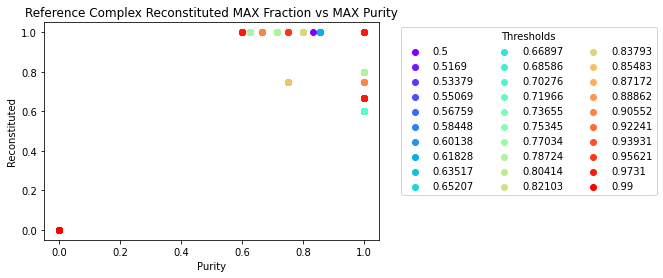

In [ ]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 30)]

plt.clf()
fig, ax = plt.subplots()
plt.title('Reference Complex Reconstituted MAX Fraction vs MAX Purity')
for idx, thresh, color in zip(np.arange(30), np.linspace(0.50, 0.99, 30), colors):
  plt.scatter(x=xMat_max[idx, :], y=yMat_max[idx, :], label=round(thresh, 5), color=color)
plt.xlabel('Purity')
plt.ylabel('Reconstituted')
plt.legend(title='Thresholds', bbox_to_anchor=(1.05, 1), ncol=3)
fig.savefig('reconFrac_vPurity_varyThresholds_max.svg', bbox_inches='tight', dpi=1200, format='svg')

<Figure size 432x288 with 0 Axes>

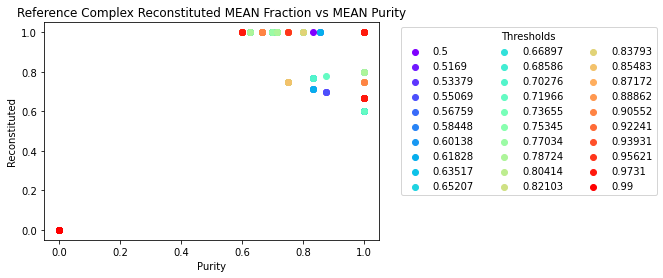

In [ ]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 30)]

plt.clf()
fig, ax = plt.subplots()
plt.title('Reference Complex Reconstituted MEAN Fraction vs MEAN Purity')
for idx, thresh, color in zip(np.arange(30), np.linspace(0.50, 0.99, 30), colors):
  plt.scatter(x=xMat_mean[idx, :], y=yMat_mean[idx, :], label=round(thresh, 5), color=color)
plt.xlabel('Purity')
plt.ylabel('Reconstituted')
plt.legend(title='Thresholds', bbox_to_anchor=(1.05, 1), ncol=3)
fig.savefig('reconFrac_vPurity_varyThresholds_mean.svg', bbox_inches='tight', dpi=1200, format='svg')

###Main2

In [ ]:
pickle.dump(corum2018Complexes_humanGeneids, open('./corum2018Complexes_humanGeneids_protocol2.pkl', 'wb'), protocol=2)

In [ ]:
'''
importlib.reload(getData)
importlib.reload(getComplexes)
importlib.reload(getPairs_analysis)
importlib.reload(getComplexes_analysis)
importlib.reload(getAllCliques_gwMods)
try:
  os.remove('./referenceRecap_vPurity_scatter.svg')
  os.remove('./cliqueGrouped_CORUMcomparisons.svg')
except:
  pass
try:
  os.remove('./results.pkl')
except:
  pass
try:
  os.remove('./complexPredictions_partitionModel_thresh=0.5.csv')
  os.remove('./complexPredictions_partitionModel_thresh=0.99.csv')
  os.remove('./cliqueTable.csv')
  os.remove('./cliqueTable_simplified.csv')
  os.remove('./recapPurity_df.csv')
except:
  pass
try:
  #shutil.rmtree('./complexPredictions_partitionModel_thresh=0.5')
  shutil.rmtree('./complexPredictions_partitionModel_thresh=0.99')
except:
  pass
'''

for idx, thresh in enumerate(np.linspace(0.1, 0.2, 3)):
  outputPrefix = 'complexPredictions_partitionModel_thresh='+str(thresh)

  print('    complex generation phase...')
  getComplexes_analysis.generateInputs_complexBuilder(
      allInteractions_nonSpecific,
      ['geneIDi', 'geneIDii'], 'confidenceVals',
      outputPrefix, complexBuilder_threshold=thresh, runBuilder=True)

  print('    complex prediction\'s organization simplification phase...')
  predictions = getComplexes_analysis.getComplex_predictions(
      complexesPath,
      outputPrefix,
      realDir=False)

  predictionsComplete = []
  listKeys = list(predictions.keys())
  for key in listKeys:
    predictionsComplete = predictionsComplete + predictions[key]
    del predictions[key]
  predictionsComplete2 = pd.DataFrame(
      list(zip(np.arange(len(predictionsComplete)), predictionsComplete))
  )
  predictionsComplete2.to_csv('./' + outputPrefix + '.csv',
                             index=False,
                             header=None)

  '''
  print('    complex predictions analysis phase...')
  getComplexes_analysis.compareContrast_referenceExperimental_complexes(corum2018Complexes_humanGeneids,
                                                                        predictionsComplete,
                                                                        verbose=True)
  '''
  '''
  targetPath = './' + outputPrefix + '/results/'
  os.mkdir(targetPath)
  print('    ...moving files...')
  for pklFiles in Path('./').glob('*.pkl'):
    shutil.copy(pklFiles, targetPath)
    os.remove(pklFiles)
  for csvFiles in Path('./').glob('*.csv'):
    shutil.copy(csvFiles, targetPath)
    os.remove(csvFiles)
  for svgFiles in Path('./').glob('*.svg'):
    shutil.copy(svgFiles, targetPath)
    os.remove(svgFiles)
  '''

    complex generation phase...
For reference, the command passing to the complex builder is as follows: 
python ./util/getAllCliques_gwMods.py ./complexPredictions_partitionModel_thresh=0.1/complexPredictions_partitionModel_thresh=0.1_pairsInfo.tsv ./complexPredictions_partitionModel_thresh=0.1/complexPredictions_partitionModel_thresh=0.1_pairsPredictions 0.1 .
b''
    complex prediction's organization simplification phase...
    complex generation phase...
For reference, the command passing to the complex builder is as follows: 
python ./util/getAllCliques_gwMods.py ./complexPredictions_partitionModel_thresh=0.15000000000000002/complexPredictions_partitionModel_thresh=0.15000000000000002_pairsInfo.tsv ./complexPredictions_partitionModel_thresh=0.15000000000000002/complexPredictions_partitionModel_thresh=0.15000000000000002_pairsPredictions 0.15000000000000002 .
b''
    complex prediction's organization simplification phase...
    complex generation phase...
For reference, the command

In [ ]:
iterPaths = [dir for dir in glob.glob('./complexPredictions_partitionModel_thresh=*')]
iterPaths

['./complexPredictions_partitionModel_thresh=0.8674999999999999',
 './complexPredictions_partitionModel_thresh=0.3',
 './complexPredictions_partitionModel_thresh=0.37',
 './complexPredictions_partitionModel_thresh=0.45',
 './complexPredictions_partitionModel_thresh=0.5',
 './complexPredictions_partitionModel_thresh=0.43',
 './complexPredictions_partitionModel_thresh=0.31',
 './complexPredictions_partitionModel_thresh=0.4',
 './complexPredictions_partitionModel_thresh=0.745',
 './complexPredictions_partitionModel_thresh=0.35',
 './complexPredictions_partitionModel_thresh=0.6225',
 './complexPredictions_partitionModel_thresh=0.25',
 './complexPredictions_partitionModel_thresh=0.49']

In [ ]:
iterIDs

['0.25',
 '0.3',
 '0.31',
 '0.35',
 '0.37',
 '0.4',
 '0.43',
 '0.45',
 '0.49',
 '0.5',
 '0.6225',
 '0.745',
 '0.8674999999999999']

In [ ]:
iterPaths

['./complexPredictions_partitionModel_thresh=0.8674999999999999',
 './complexPredictions_partitionModel_thresh=0.3',
 './complexPredictions_partitionModel_thresh=0.37',
 './complexPredictions_partitionModel_thresh=0.45',
 './complexPredictions_partitionModel_thresh=0.5',
 './complexPredictions_partitionModel_thresh=0.43',
 './complexPredictions_partitionModel_thresh=0.31',
 './complexPredictions_partitionModel_thresh=0.4',
 './complexPredictions_partitionModel_thresh=0.745',
 './complexPredictions_partitionModel_thresh=0.35',
 './complexPredictions_partitionModel_thresh=0.6225',
 './complexPredictions_partitionModel_thresh=0.25',
 './complexPredictions_partitionModel_thresh=0.49']

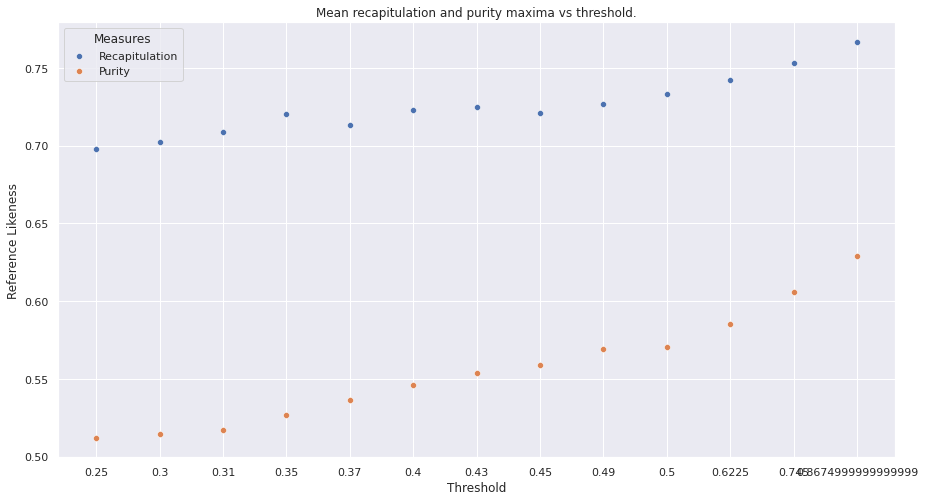

In [ ]:
dirs = glob.glob('./complexPredictions_partitionModel_thresh=*')
dirs.sort()
dirIDs = [dir.split('=')[1] for dir in dirs]

recapMean_maxima = []
purityMean_maxima = []
for path in dirs:
    results = pickle.load(open(path+'/results/results.pkl', 'rb'))
    recapMean_maxima.append(statistics.mean(list(results['maxOverlap'].values())))
    purityMean_maxima.append(statistics.mean(list(results['maxPurity'].values())))

meanMaxima_recap = pd.DataFrame(list(zip(dirIDs, recapMean_maxima)), columns=['Threshold', 'Reference Likeness'])
meanMaxima_purity = pd.DataFrame(list(zip(dirIDs, purityMean_maxima)), columns=['Threshold', 'Reference Likeness'])

plt.clf()
plt.title('Mean recapitulation and purity maxima vs threshold.')
sns.color_palette("Paired")
sns.scatterplot(data=meanMaxima_recap, x="Threshold", y="Reference Likeness", label="Recapitulation")
sns.scatterplot(data=meanMaxima_purity, x="Threshold", y="Reference Likeness", label="Purity")
plt.legend(title='Measures')
plt.savefig('./referenceRecap_vPurity_scatter_rangeThresholds.svg', bbox_inches='tight', dpi=1200, format='svg')

No handles with labels found to put in legend.


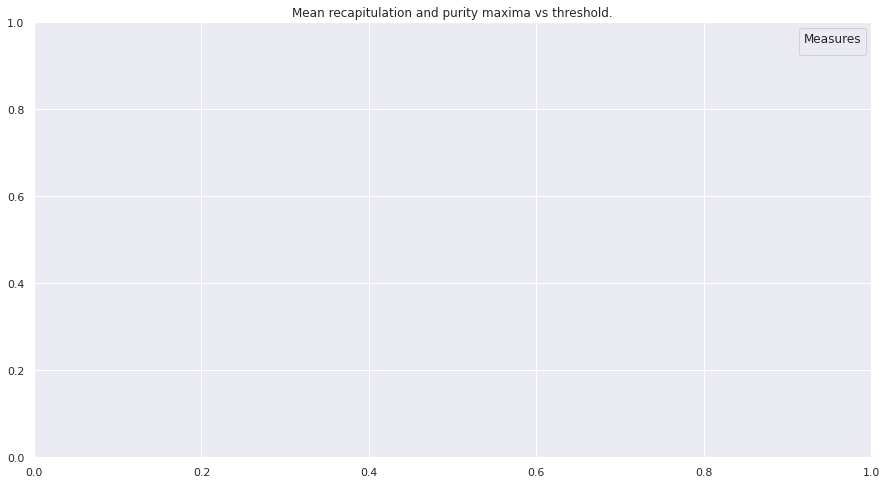

In [ ]:
plotScatter_meanMaxima_thresholdRange('/.complexPredictions_partitionModel_thresh=0.*', '=')

In [ ]:
print('initialization phase...')
srPreds_acrossThresholds_ji6 = dict()
lrPreds_acrossThresholds_ji6 = dict()
srPreds_acrossThresholds_ji5 = dict()
lrPreds_acrossThresholds_ji5 = dict()
reconFrac_maxAcross_thresholds = dict()
reconFrac_meanAcross_thresholds = dict()
purityFrac_maxAcross_thresholds = dict()
purityFrac_meanAcross_thresholds = dict()

print('iterative phase...')
for idx, thresh in zip(np.arange(30), np.linspace(0.1, 0.9, 10)):
  outputPrefix = 'complexPredictions_partitionModel_thresh='+str(thresh)

  print('    complex generation phase...')
  getComplexes_analysis.generateInputs_complexBuilder(
      allInteractions_nonSpecific,
      ['geneIDi', 'geneIDii'], 'confidenceVals',
      outputPrefix, complexBuilder_threshold=thresh, runBuilder=True)

  print('    complex prediction\'s organization simplification phase...')
  predictions = getComplexes_analysis.getComplex_predictions(
      complexesPath,
      outputPrefix,
      realDir=False)
  predictionsComplete = []
  listKeys = list(predictions.keys())
  for key in listKeys:
    predictionsComplete = predictionsComplete + predictions[key]
    del predictions[key]
  predictionsComplete = \
    dict(zip(np.arange(len(predictionsComplete)), predictionsComplete))

  print('    complex predictions analysis phase...')
  srPreds_acrossThresholds_ji6[idx] = getComplexes_analysis.quickCompare_contrast(ribosomalSubunits_multipleIDs['smallRibosomal_subunitGeneid'], predictionsComplete, returnResults=True)
  lrPreds_acrossThresholds_ji6[idx] = getComplexes_analysis.quickCompare_contrast(ribosomalSubunits_multipleIDs['largeRibosomal_subunitGeneid'], predictionsComplete, returnResults=True)
  srPreds_acrossThresholds_ji5[idx] = getComplexes_analysis.quickCompare_contrast(ribosomalSubunits_multipleIDs['smallRibosomal_subunitGeneid'], predictionsComplete, jindex=0.001, returnResults=True)
  lrPreds_acrossThresholds_ji5[idx] = getComplexes_analysis.quickCompare_contrast(ribosomalSubunits_multipleIDs['largeRibosomal_subunitGeneid'], predictionsComplete, jindex=0.001, returnResults=True)
  reconFrac_maxAcross_thresholds[idx], reconFrac_meanAcross_thresholds[idx], purityFrac_maxAcross_thresholds[idx], purityFrac_meanAcross_thresholds[idx] = \
    getComplexes_analysis.compareContrast_all(corum2018Complexes_humanSubset['corum2018Complexes_humanGeneids'], predictionsComplete, similarityMetric=0.1)
  pickle.dump(
      {'srPreds_acrossThresholds_ji6': srPreds_acrossThresholds_ji6[idx],
       'lrPreds_acrossThresholds_ji6': lrPreds_acrossThresholds_ji6[idx],
       'srPreds_acrossThresholds_ji5': srPreds_acrossThresholds_ji5[idx],
       'lrPreds_acrossThresholds_ji5': lrPreds_acrossThresholds_ji5[idx],
       'reconFrac_maxAcross_thresholds': reconFrac_maxAcross_thresholds[idx]},
       open('./predsAnalysis' + str(thresh) +'_cmpCORUM-human.pkl', 'wb'))

In [ ]:
wlm_corumAnalyses = \
  {
      'srPreds_acrossThresholds_ji6': srPreds_acrossThresholds_ji6,
   'lrPreds_acrossThresholds_ji6': lrPreds_acrossThresholds_ji6,
   'srPreds_acrossThresholds_ji5': srPreds_acrossThresholds_ji5,
   'lrPreds_acrossThresholds_ji5': lrPreds_acrossThresholds_ji5,
   'reconFrac_maxAcross_thresholds': reconFrac_maxAcross_thresholds,
   'reconFrac_meanAcross_thresholds': reconFrac_meanAcross_thresholds,
   'purityFrac_maxAcross_thresholds': purityFrac_maxAcross_thresholds,
   'purityFrac_meanAcross_thresholds': purityFrac_meanAcross_thresholds
   }

pickle.dump(wlm_corumAnalyses, open('./wlm_corumAnalyses_reconPlus_purity.pkl', 'wb'))

In [ ]:
wlm_corumAnalyses = \
  pickle.load(open('/content/wlm_corumAnalyses_reconPlus_purity.pkl', 'rb'))

reconFrac_maxAcross_thresholds = wlm_corumAnalyses['reconFrac_maxAcross_thresholds']
reconFrac_meanAcross_thresholds = wlm_corumAnalyses['reconFrac_meanAcross_thresholds']
purityFrac_maxAcross_thresholds = wlm_corumAnalyses['purityFrac_maxAcross_thresholds']
purityFrac_meanAcross_thresholds = wlm_corumAnalyses['purityFrac_meanAcross_thresholds']

In [ ]:
xMat_max = np.zeros((30, 409))
yMat_max = np.zeros((30, 409))
xMat_mean = np.zeros((30, 409))
yMat_mean = np.zeros((30, 409))
for idx in np.arange(30):
  xMat_max[idx, :] = reconFrac_maxAcross_thresholds[idx].reshape(xMat_max[idx, :].shape)
  yMat_max[idx, :] = purityFrac_maxAcross_thresholds[idx].reshape(yMat_max[idx, :].shape)
  xMat_mean[idx, :] = reconFrac_meanAcross_thresholds[idx].reshape(xMat_mean[idx, :].shape)
  yMat_mean[idx, :] = purityFrac_meanAcross_thresholds[idx].reshape(yMat_mean[idx, :].shape)

<Figure size 432x288 with 0 Axes>

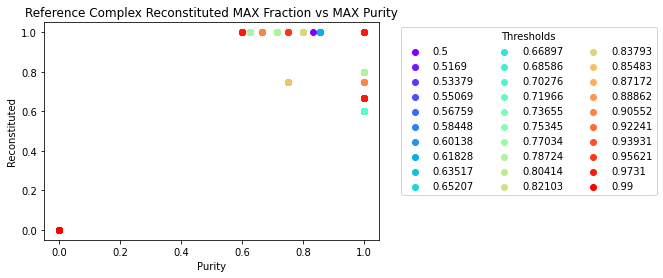

In [ ]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 30)]

plt.clf()
fig, ax = plt.subplots()
plt.title('Reference Complex Reconstituted MAX Fraction vs MAX Purity')
for idx, thresh, color in zip(np.arange(30), np.linspace(0.50, 0.99, 30), colors):
  plt.scatter(x=xMat_max[idx, :], y=yMat_max[idx, :], label=round(thresh, 5), color=color)
plt.xlabel('Purity')
plt.ylabel('Reconstituted')
plt.legend(title='Thresholds', bbox_to_anchor=(1.05, 1), ncol=3)
fig.savefig('reconFrac_vPurity_varyThresholds_max.svg', bbox_inches='tight', dpi=1200, format='svg')

<Figure size 432x288 with 0 Axes>

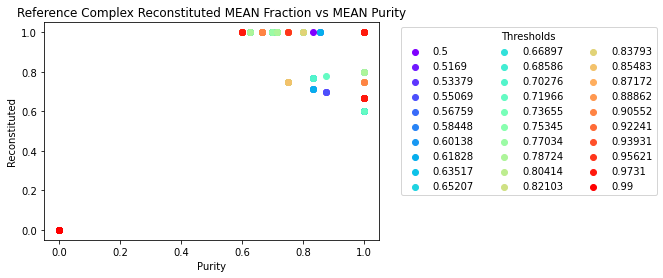

In [ ]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 30)]

plt.clf()
fig, ax = plt.subplots()
plt.title('Reference Complex Reconstituted MEAN Fraction vs MEAN Purity')
for idx, thresh, color in zip(np.arange(30), np.linspace(0.50, 0.99, 30), colors):
  plt.scatter(x=xMat_mean[idx, :], y=yMat_mean[idx, :], label=round(thresh, 5), color=color)
plt.xlabel('Purity')
plt.ylabel('Reconstituted')
plt.legend(title='Thresholds', bbox_to_anchor=(1.05, 1), ncol=3)
fig.savefig('reconFrac_vPurity_varyThresholds_mean.svg', bbox_inches='tight', dpi=1200, format='svg')

###Main3

In [ ]:
corum2018_humanComplexes_multFormats = pickle.load(open('/content/corum2018Complexes_humanSubset.pkl', 'rb'))

In [ ]:
pickle.dump(corum2018_humanComplexes_multFormats, open('corum2018_humanComplexes_multFormats_protocol2.pkl', 'wb'), protocol=2)

In [ ]:
drew2017_drew2021_lm2019_stringClusters = pickle.load(open('drew2017_drew2021_lm2019_stringClusters.pkl', 'rb'))

In [ ]:
pickle.dump(drew2017_drew2021_lm2019_stringClusters,
            open('drew2017_drew2021_lm2019_stringClusters_protocol2.pkl', 'wb'), protocol=2)

In [ ]:
corum2018Complexes_humanGeneids2 = pd.DataFrame(
    list(
        zip(
            np.arange(len(corum2018Complexes_humanGeneids)),
            corum2018Complexes_humanGeneids)
        )
    )

corum2018Complexes_humanGeneids2 = \
  corum2018Complexes_humanGeneids2.apply(lambda x: list(x.loc[1]), axis=1)

corum2018Complexes_humanGeneids2.to_csv(
    './corum2018Complexes_humanGeneids.txt',
    index=False,
    header=None)

In [ ]:
corum2018Complexes_humanGeneids2 = \
  pd.DataFrame(list(corum2018Complexes_humanGeneids))

corum2018Complexes_humanGeneids2 = \
  corum2018Complexes_humanGeneids2.apply(lambda x: list(x.loc[1]), axis=1)
corum2018Complexes_humanGeneids2.to_csv('./corum2018Complexes_humanGeneids.csv',
                                        index=False,
                                        header=None)

In [ ]:
gold_standard_complexes = []
gold_file = open('./corum2018Complexes_humanGeneids.csv', "rb")
for line in gold_file.readlines():
    gold_standard_complexes.append(line.split())
gold_file.close()

In [ ]:
predictionsPath = './predictionsDir/'
os.mkdir(predictionsPath)
for idx, thresh in zip(np.arange(20), np.linspace(0.25, 0.99, 20)):
  outputPrefix = 'complexPredictions_partitionModel_thresh='+str(thresh)

  print('    complex generation phase...')
  getComplexes_analysis.generateInputs_complexBuilder(
      allInteractions_nonSpecific,
      ['geneIDi', 'geneIDii'], 'confidenceVals',
      outputPrefix, complexBuilder_threshold=thresh, runBuilder=True)

  print('    complex prediction\'s organization simplification phase...')
  predictions = getComplexes_analysis.getComplex_predictions(
      complexesPath,
      outputPrefix,
      realDir=False)

  predictionsComplete = []
  listKeys = list(predictions.keys())
  for key in listKeys:
    predictionsComplete = predictionsComplete + predictions[key]
    del predictions[key]
  predictionsComplete2 = pd.DataFrame(
      list(zip(np.arange(len(predictionsComplete)), predictionsComplete))
  )
  predictionsComplete2.drop(columns=[0], inplace=True)
  predictionsComplete2 = \
    predictionsComplete2.apply(
        lambda x: str(list(x.loc[1])).replace('[', '').replace(']', ''), axis=1)
  predictionsComplete2.to_csv('./' + outputPrefix + '.csv',
                             index=False,
                             header=None)

  '''
  print('    complex predictions analysis phase...')
  getComplexes_analysis.compareContrast_referenceExperimental_complexes(corum2018Complexes_humanGeneids,
                                                                        predictionsComplete,
                                                                        verbose=True)
  '''

  '''
  targetPath = './' + outputPrefix + '/results/'
  os.mkdir(targetPath)
  print('    ...moving files...')
  '''
  for pklFiles in Path('./').glob('*.pkl'):
    shutil.copy(pklFiles, targetPath)
    os.remove(pklFiles)
  '''
  for predictionsFile in Path('./').glob('complexPredictions_partitionModel_thresh=0.*.csv'):
    shutil.copy(predictionsFile, predictionsPath)
    os.remove(predictionsFile)
  for csvFile in Path('./').glob('*.csv'):
    shutil.copy(csvFile, targetPath)
    os.remove(csvFile)
  '''
  for svgFiles in Path('./').glob('*.svg'):
    shutil.copy(svgFiles, targetPath)
    os.remove(svgFiles)

    complex generation phase...
For reference, the command passing to the complex builder is as follows: 
python ./util/getAllCliques_gwMods.py ./complexPredictions_partitionModel_thresh=0.25/complexPredictions_partitionModel_thresh=0.25_pairsInfo.tsv ./complexPredictions_partitionModel_thresh=0.25/complexPredictions_partitionModel_thresh=0.25_pairsPredictions 0.25 .
b"['./util/getAllCliques_gwMods.py', './complexPredictions_partitionModel_thresh=0.25/complexPredictions_partitionModel_thresh=0.25_pairsInfo.tsv', './complexPredictions_partitionModel_thresh=0.25/complexPredictions_partitionModel_thresh=0.25_pairsPredictions', '0.25', '.']\n# of nodes 1590\n# of edges 15310\n52\n"
    complex prediction's organization simplification phase...
    complex generation phase...
For reference, the command passing to the complex builder is as follows: 
python ./util/getAllCliques_gwMods.py ./complexPredictions_partitionModel_thresh=0.2889473684210526/complexPredictions_partitionModel_thresh=0.28

In [ ]:
predicted_clusters = []
clpred_f = open(args.cluster_filename,"rb")
for line in clpred_f.readlines():
    predicted_clusters.append(line.split())
clpred_f.close()